# Классификация токсичности комментариев

Интернет-магазин "Викишоп" внедряет новый сервис, который позволяет пользователям редактировать и дополнять описания товаров, подобно вики-сообществам. Это означает, что клиенты могут предлагать свои правки и комментировать изменения, внесенные другими пользователями. Нам необходим инструмент, который сможет автоматически обнаруживать токсичные комментарии и отправлять их на модерацию.

Цель данного проекта заключается в обучении модели, способной классифицировать комментарии на позитивные и негативные с высокой точностью. У нас есть набор данных с разметкой, определяющей токсичность комментариев. Нашей задачей является построение модели, которая достигнет значения метрики качества F1 не менее 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier

import numpy as np
import warnings
np.warnings = warnings
warnings.filterwarnings('ignore')

%pip install missingno
import missingno as msno

%pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



In [2]:
# Импортируем датасет
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [3]:
# Основная информация
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
# Первые 5 строк
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


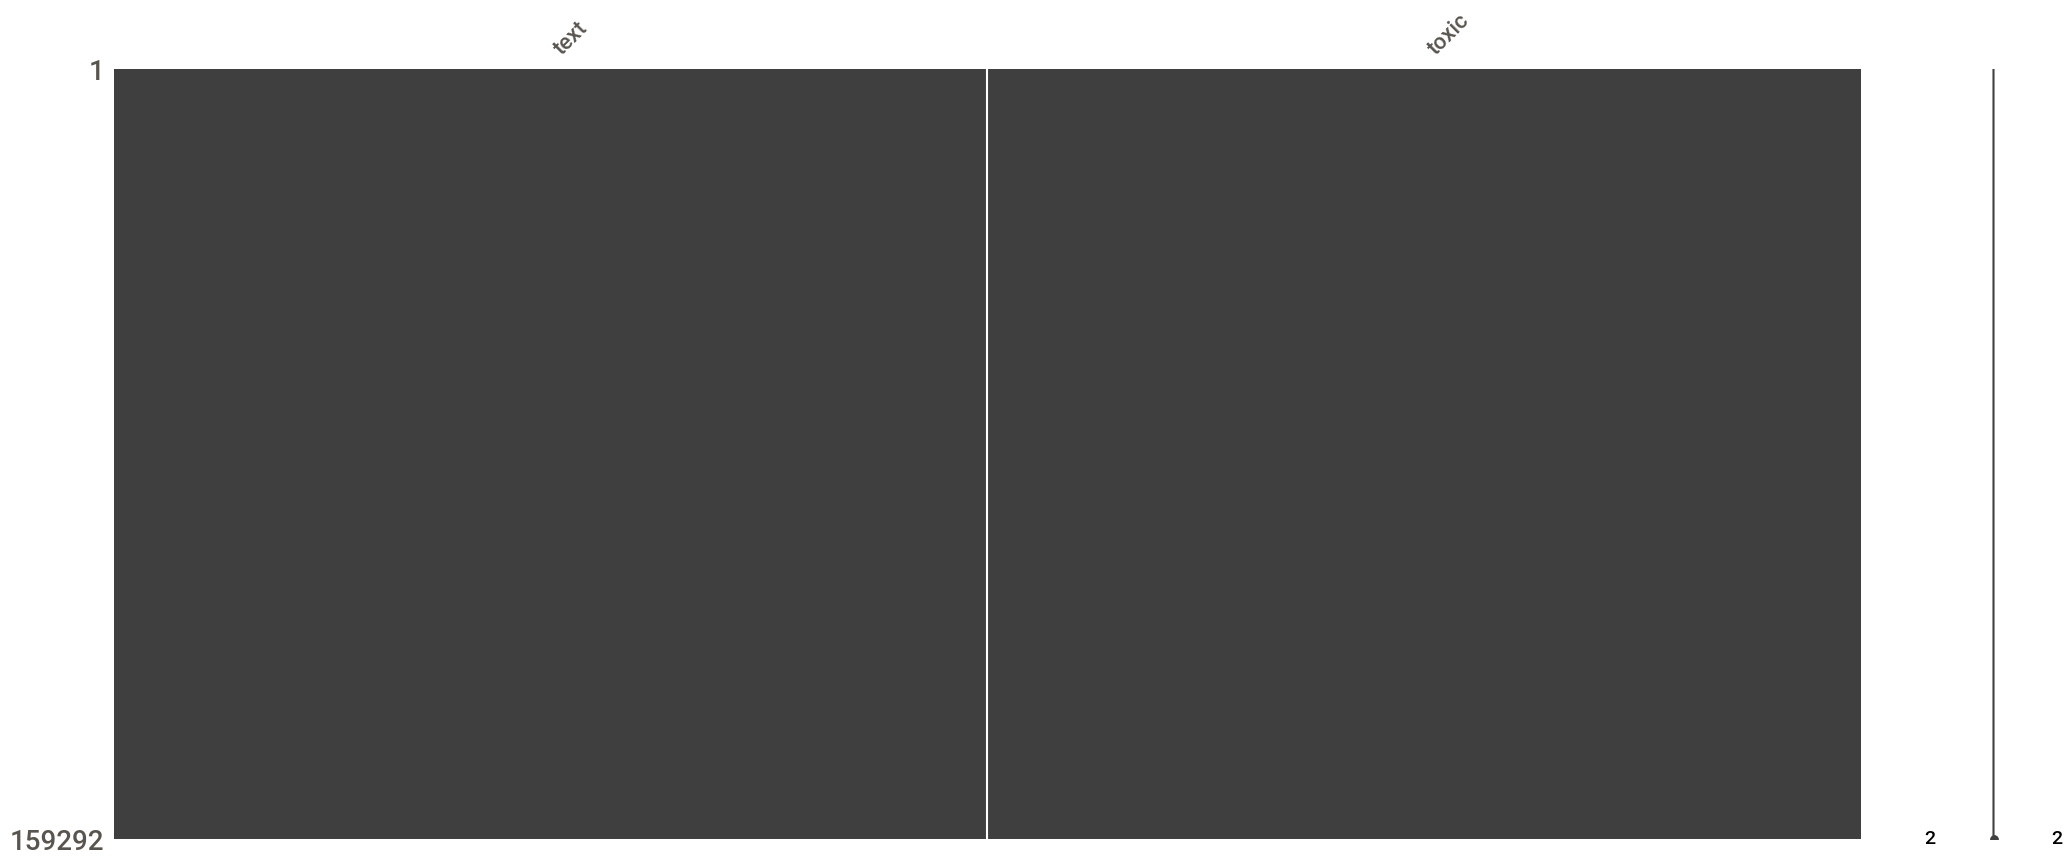

In [6]:
# Визуальное отоборажение пропусков
msno.matrix(df);

По предварительному анализу можно выделить:
- В данных отсуствуют пропуски
- В данных отсуствуют явные дубликаты
- Имеется дисбаланс классов в целевом признаке. Класс 1 равен 10%, а класс 0 равено 90%. Токсичных комментариев значительно меньше

### Предобработка текста

Перед работой моделей, нужно подготовить столбец `text`.

Шаги, которые будут сделаны по обработке текста:
- Очистка от регулярных выражений и приведение к нижнему регистру
- Разбиение текста на токены
- Удаление стоп-слов
- Лемматизация текста

Загрузим все необходимые пакеты

In [7]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jumpus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Jumpus\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jumpus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jumpus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [9]:
# Функция производит предобработку текста
def preprocess_text(text):
    
    # Очистка текста от регулярных выражений
    cleaned_text = re.sub(r'[^a-zA-Z ]', '', text).lower()
    
    # Токенизация текста
    tokens = nltk.word_tokenize(cleaned_text) 
    
    # Удаление стоп-слов
    tokens_without_stopwords = [token for token in tokens if token not in stop_words]  
    
    # Лемматизация текста
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens_without_stopwords]
    
    # Объединение лемм в строку
    preprocessed_text = ' '.join(lemmas) 
    
    return preprocessed_text

In [10]:
print('Исходный текст:', df.loc[0,'text'])
print()
print('Текст после лемматизации:', preprocess_text(df.loc[0,'text']))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Текст после лемматизации: explanationwhy edits make username hardcore metallica fan revert werent vandalism closure gas vote new york doll fac please dont remove template talk page since im retire


In [11]:
%%time
#df['lemm_text'] = df['text'].apply(preprocess_text)

CPU times: total: 0 ns
Wall time: 0 ns


Сохраним результаты лемматизации в файле CSV

In [12]:
#df.to_csv('lemm_toxic_comments_2.csv', index=False)

In [13]:
df = pd.read_csv('lemm_toxic_comments_2.csv')

#### Разделим датасет на выборки

Разделим датафрейм на обучающую и тестовую выборки в пропорциях 80% к 20% соответственно. Так же разделим датасет на `features` и `target`.

Признаки - `text` — текст комментария

Целевой признак - `toxic` — оценка токсичности комментария (1 - да, 0 - нет)

In [14]:
state = 12345

In [15]:
# Разделим датасет на обучающую и тестовую выборку с выделением features и target
train_features, test_features, train_target, test_target = train_test_split(
    df['lemm_text'], df['toxic'], test_size=0.25, random_state=state)

In [16]:
print('Размер обучающей выборки признаков:', train_features.shape[0])
print('Размер тестовой выборки признаков:', test_features.shape[0])
print('Размер обучающей выборки целевого признака:', train_target.shape[0])
print('Размер тестовой выборки целевого признака:', test_target.shape[0])

Размер обучающей выборки признаков: 119469
Размер тестовой выборки признаков: 39823
Размер обучающей выборки целевого признака: 119469
Размер тестовой выборки целевого признака: 39823


#### Вычислим TF-IDF для корпуса текстов

In [17]:
# Заполним появившиеся пропуски
train_features.fillna(value='пропуск', inplace=True)
test_features.fillna(value='пропуск', inplace=True)

In [18]:
# Создаем экземпляр TfidfVectorizer
count_tf_idf = TfidfVectorizer()  

# Применяем fit_transform к обучающему корпусу
train_tf_idf = count_tf_idf.fit_transform(train_features)  

# Применяем transform к тестовому корпусу
test_tf_idf = count_tf_idf.transform(test_features)  

Выведем размер корпусов.

In [19]:
print('Размер обучающей выборки:', train_tf_idf.shape[0])
print('Размер тестовой выборки:', test_tf_idf.shape[0])

Размер обучающей выборки: 119469
Размер тестовой выборки: 39823


### Вывод по предобработке текста

На этом этапе сделаны такие шаги:

- Очистили текст от регулярных выражений и привели к нижнему регистру
- Разбили текста на токены
- Удалили стоп-слова
- Лемматизировали текст
- Разделили датасет на обучающую и тестовую выборку
- Вычислии TF-IDF для корпуса текстов

## Обучение

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. Оценивать будем по метрике качества F1. Значение этой метрики должно быть не ниже 0.75.

Модели, которые будем обучать:
- LogisticRegression
- CatBoostClassifier
- LGBMClassifier

На этапе предобаботки мы отметили, что в данных присуствует дисбаланс классов. Что бы его избежать воспользуемся гиперпараметром `class_weight` и присвоим ему значение `balanced`. Это сбалансирует наши классы.

In [20]:
# Создаем пустой DataFrame с заданными столбцами
results_df = pd.DataFrame(columns=['model', 'f1_train'])

In [21]:
def train_model(model, params, train_features, train_target, test_features, results_df, verbose=None):
    
    # Создаем объект GridSearchCV для поиска по сетке
    grid = GridSearchCV(model, param_grid=params, cv=5, scoring='f1')
    
    # Обучаем модель без вывода информации о процессе обучения
    if verbose is None:
        grid.fit(train_features, train_target)
    else:
        grid.fit(train_features, train_target, verbose=False)
    
    # Получаем лучший результат и параметры из объекта GridSearchCV
    best_score = grid.best_score_
    best_params = grid.best_params_
    
    # Добавляем результаты в таблицу
    results_df.loc[len(results_df)] = [model.__class__.__name__, best_score]
    
    print('Лучшие гиперпараметры:', best_params)
    print(results_df.loc[results_df['model'] == model.__class__.__name__])
    
    return best_params

### Модель логистической регрессии

In [22]:
%%time
# Задаем гиперпараметры
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

# Вызываем функцию train_model для обучения модели
log_reg_best_params = train_model(
    LogisticRegression(class_weight='balanced'), 
    log_reg_params, 
    train_tf_idf, 
    train_target, 
    test_tf_idf, 
    results_df
)

Лучшие гиперпараметры: {'C': 11.1112}
                model  f1_train
0  LogisticRegression  0.760549
CPU times: total: 3min 27s
Wall time: 3min 9s


### Модель градиентного бустинга CatBoost

In [23]:
%%time
# Задаем гиперпараметры
cat_boost_params = {'iterations': [500]}

# Вызываем функцию train_model для обучения модели
cat_boost_best_params = train_model(
    CatBoostClassifier(random_state=state, auto_class_weights='Balanced'), 
    cat_boost_params, 
    train_tf_idf, 
    train_target,
    test_tf_idf, 
    results_df, 
    verbose=False
)

Лучшие гиперпараметры: {'iterations': 500}
                model  f1_train
1  CatBoostClassifier  0.743613
CPU times: total: 4h 17min 37s
Wall time: 41min 2s


### Модель градиентного бустинга LightGBM

In [24]:
%%time
# Задаем гиперпараметры
lgbm_params = {'max_depth': [12, 16], 'n_estimators': [250, 500]}

# Вызываем функцию train_model для обучения модели
lgbm_best_params = train_model(
    LGBMClassifier(random_state=state, class_weight='balanced'),
    lgbm_params,
    train_tf_idf,
    train_target,
    test_tf_idf,
    results_df
)

Лучшие гиперпараметры: {'max_depth': 16, 'n_estimators': 500}
            model  f1_train
2  LGBMClassifier  0.755762
CPU times: total: 2h 13min 37s
Wall time: 11min 45s


In [25]:
# Выведем результаты
results_df

,model,f1_train
0,LogisticRegression,0.760549
1,CatBoostClassifier,0.743613
2,LGBMClassifier,0.755762


### Проверим лучшую модель на тестовой выборке

Самую высоку метрику качества показала модель логистической регрессии. 

In [26]:
# Создаем экземпляр модели Logistic Regression с заданными параметрами
log_reg_model = LogisticRegression(class_weight='balanced', **log_reg_best_params)  

# Обучаем модель на обучающих признаках и целевой переменной
log_reg_model.fit(train_tf_idf, train_target)  

# Делаем предсказания на тестовых признаках с помощью обученной модели
predictions = log_reg_model.predict(test_tf_idf)  

# Вычисляем F1-меру между предсказаниями и целевой переменной тестовых данных
f1_test = f1_score(test_target, predictions)  

# Выводим значение F1-меры на тестовых данных
print(f1_test)  

0.7706422018348623


### Вывод по этаму обучения

Лучший результат показала модель Логистическо регресии. Можно отметить низкую разницу между значениями F1 для обучающей и тестовой выборок. Это указывает на то, что модели обладают низким уровнем переобучения и хорошо обобщают обученные данные на новые примеры.

## Вывод по проекту

В этом проекте нам нужно было обучить модель классифицировать комментарии на позитивные и негативные. Результат оценивался метрикой качества F1. Значение этой метрики должно было быть не ниже 0.75.

В этом проекте было сделано:

1. Предварительный анализ данных:

- Проверили на наличие пропусков.
- Проверили на наличие явных дубилкатов.
- Выявили дисбаланс классов в целевом признаке.

2. Предобработка данных:

- Очистили текст от регулярных выражений.
- Разбили текст на токены.
- Удалили стоп-слова.
- Лемматизировали текст.

3. Разделение датасета:

- Разделили данные на обучающую и тестовую выборку.

4. Вычисление TF-IDF:

- Вычислили значения TF-IDF (Term Frequency-Inverse Document Frequency) для корпуса текстов.

5. Обучение моделей:

- Использовали три модели для классификации комментариев: LogisticRegression, CatBoostClassifier и LGBMClassifier.
- Использовали гиперпараметр class_weight с значением "balanced" для борьбы с дисбалансом классов.

6. Собрали результаты в таблицу results_df.

7. Выбрали лучшую модель и проверили её на тестовой выборке.

Лучшая модель оказалась Логистическая регрессия. Нам удалось получить метрику F1 выше 0.75.